In [3]:
import os, sys
sys.path.append("..")


import matplotlib
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from IPython.display import clear_output

from PIL import Image
from src.tools import compute_l1_norm, ewma, ImageBatchSampler, read_images_to_ram
from src.icnn import ConvICNN128
import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.cuda.set_device(2)

## Parameters

In [5]:
INPUT = '../data/summer2winter_yosemite/trainA/'
OUTPUT = '../data/summer2winter_yosemite/trainB/'
BATCH_SIZE = 8
LAMBDA = 35000
L1 = 1e-10
LR = 1e-4
LOAD_PRETRAINED_INIT = False


## Data Loading

In [6]:
X_data = read_images_to_ram(INPUT)
Y_data = read_images_to_ram(OUTPUT)

  2%|▏         | 27/1231 [00:00<00:04, 261.73it/s]

Reading images from ../data/summer2winter_yosemite/trainA/


  5%|▍         | 48/962 [00:00<00:01, 474.51it/s]

1231 succesful; 0 fails
Reading images from ../data/summer2winter_yosemite/trainB/


100%|██████████| 962/962 [00:02<00:00, 471.89it/s]

962 succesful; 0 fails


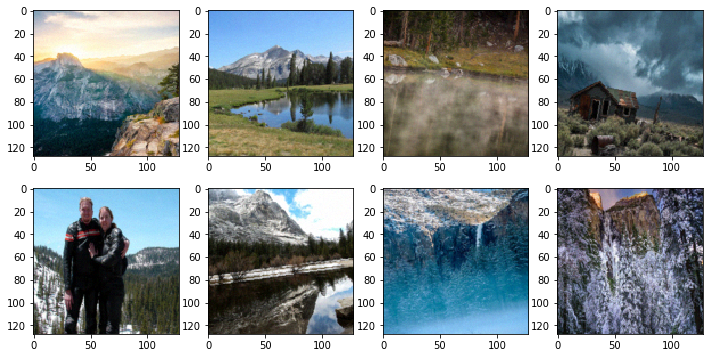

In [7]:
IMG_SIZE = 128 # To use other sized ConvICNN modification is required

extraction = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.CenterCrop(200),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.025, 0.025, 0.025, 0.025),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x+torch.randn_like(x) * 0.01),
    transforms.Lambda(lambda t: t.clamp(0,1)),
])

X_sampler = ImageBatchSampler(X_data, transform=extraction)
Y_sampler = ImageBatchSampler(Y_data, transform=extraction)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
X, Y = X_sampler.sample(4), Y_sampler.sample(4)
for i in range(4):
    axes[0, i].imshow(X[i].permute(1, 2, 0))
    axes[1, i].imshow(Y[i].permute(1, 2, 0))

## Pretraining the discriminator

In [8]:
D = ConvICNN128().cuda()
for p in D.parameters():
    p.data = torch.randn_like(p.data) / 100
D.convexify()

In [9]:
if not LOAD_PRETRAINED_INIT:
    pre_D_opt = torch.optim.Adamax(D.parameters(), lr=1e-3, betas=(0.9, 0.99))
    BLOW = 2

    D.train(True)
    loss_history = []
    for iteration in range(15000):
        XY = (torch.rand((BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), device='cuda') - .5) * BLOW + .5
        XY.requires_grad_(True)

        loss = ((D.push(XY) - XY) ** 2).mean() + L1 * compute_l1_norm(D)
        loss_history.append(np.sqrt(loss.item()))
        loss.backward()
        pre_D_opt.step()
        pre_D_opt.zero_grad()
        D.convexify()

        if iteration % 50 == 0:
            clear_output()
            print('Iteration', iteration)
            print('Current loss', loss_history[-1])

            D.train(False)

            fig = plt.figure()
            plt.plot(ewma(loss_history[-500:])[-100:])
            plt.grid()
            plt.show()

            X = X_sampler.sample(4).cuda()
            X.requires_grad_(True)
            fig, axes = plt.subplots(1, 4, figsize=(12, 3))
            for i, ax in zip(range(4), axes):
                ax.imshow(D.push(X[i][None]).cpu().detach()[0].permute(1, 2, 0).clamp(0, 1))
            plt.show()

            D.train(True)

    D.train(False)
    del loss
    del XY
    torch.cuda.empty_cache()
    
    D_conj = ConvICNN128().cuda()
    D_conj.load_state_dict(D_conj.state_dict())  
else:
    D.load_state_dict(torch.load('../models/ConvICNN_identity.tsd'))
    D_conj = ConvICNN128().cuda()
    D_conj.load_state_dict(torch.load('../models/ConvICNN_identity.tsd'))

## Main training

In [10]:
loss_history = []

In [11]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.4, 0.4))

Iteration 100000


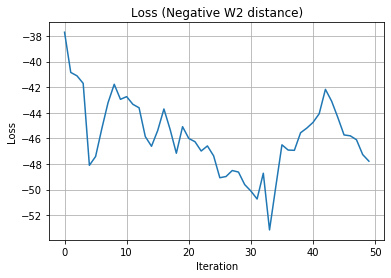

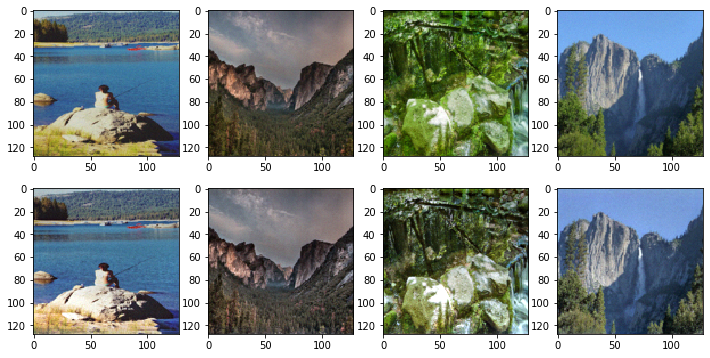

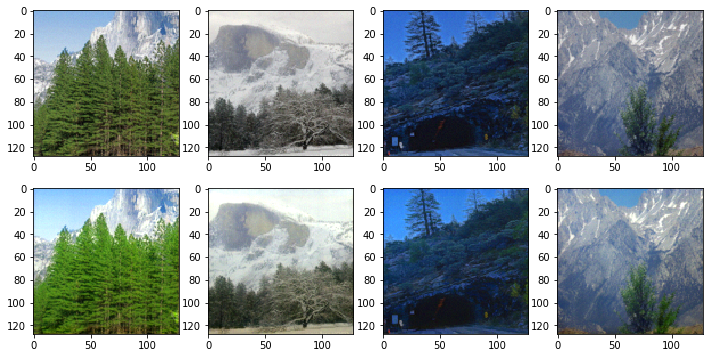

In [16]:
for iteration in range(100000):
    D_conj.train(True)
    D.train(True)
       
    X = X_sampler.sample(BATCH_SIZE).cuda()
    X.requires_grad_(True)
    
    Y = Y_sampler.sample(BATCH_SIZE).cuda()
    Y.requires_grad_(True)
        
    D_opt.zero_grad()
    D_conj_opt.zero_grad()
    
    D.train(True); D_conj.train(True)
    
    # Computing cycle loss
   
    cycle_loss = .5 * (((D_conj.push(D.push(X)) - X.detach()) ** 2).mean() + \
    ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean())
    
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()
    
    # Negative Wasserstein distance
    W_loss = (D(X) - D(Y_inv)).mean()
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).flatten(start_dim=1).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).flatten(start_dim=1).sum(dim=1) - (Y ** 2).flatten(start_dim=1).sum(dim=1) / 2 ).mean()
    
    D_reg = compute_l1_norm(D)
    D_conj_reg = compute_l1_norm(D_conj)
    
    W_loss += L1 * (D_reg + D_conj_reg)
    W_loss += LAMBDA * cycle_loss

    W_loss.backward()
    D_opt.step()
    D_conj_opt.step()
    D_conj_opt.zero_grad()
    D_opt.zero_grad()
                
    D.convexify() 
    D_conj.convexify() 
    
    loss_history.append(W_loss.item() + W_loss_nograd.item())
        
    if iteration % 100 == 0:
        clear_output(True)
        print('Iteration', iteration)
        
        fig = plt.figure(figsize=(6, 4))
        fig.add_subplot(111)
        plt.title('Loss (Negative W2 distance)')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.plot(ewma(loss_history)[-50:])
        plt.grid()
        plt.show()
        
        X = X_sampler.sample(4).cuda()
        X.requires_grad_(True)
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for i in range(4):
            X_push = D.push(X)
            axes[0, i].imshow(X[i].cpu().detach().permute(1, 2, 0).clamp(0, 1))
            axes[1, i].imshow(X_push[i].cpu().detach().permute(1, 2, 0).clamp(0, 1))
        plt.show()
        
        Y = Y_sampler.sample(4).cuda()
        Y.requires_grad_(True)
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for i in range(4):
            Y_inv = D_conj.push(Y)
            axes[0, i].imshow(Y[i].cpu().detach().permute(1, 2, 0).clamp(0, 1))
            axes[1, i].imshow(Y_inv[i].cpu().detach().permute(1, 2, 0).clamp(0, 1))
        plt.show()